In [73]:
#Import libraries
from __future__ import print_function
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K

In [31]:
#Define helper functions
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)
def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y


def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Loss")
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")

    plt.tight_layout()

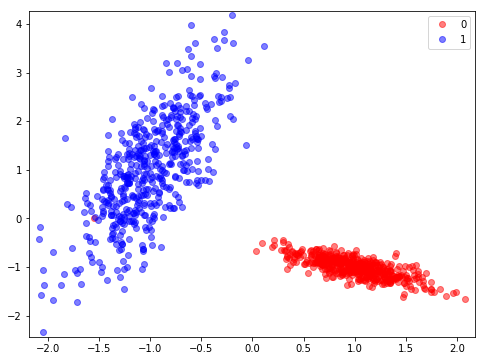

In [6]:
#To keep things simple, I won’t perform the standard practices of separating out the data to training and test sets, or performing k-fold cross-validation

#creating the graph
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                           n_informative=2, random_state=7, n_clusters_per_class=1)
plot_data(X, y)

LR coefficients: [[-4.07231906  2.09044633]]
LR intercept: [-0.23103502]


c:\users\sagi\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


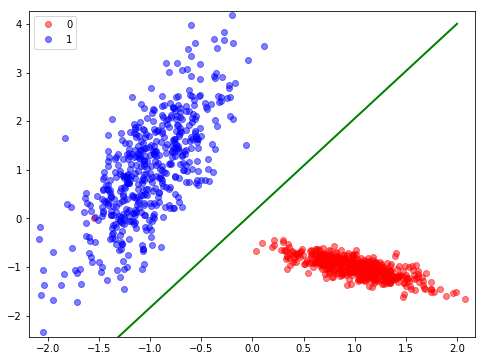

In [16]:
#splitting the graph with a boundary
lr = LogisticRegression()
lr.fit(X, y)
print('LR coefficients:', lr.coef_)
print('LR intercept:', lr.intercept_)

plot_data(X, y)
limits = np.array([-2, 2])
boundary = -(lr.coef_[0][0] * limits + lr.intercept_[0]) / lr.coef_[0][1]
plt.plot(limits, boundary, "g-", linewidth=2)

#coef_ --> Coefficient of the features in the decision function.

<Figure size 576x432 with 0 Axes>

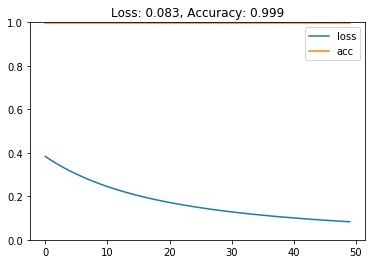

In [21]:
#Using ANN
#Define the model
model = Sequential()
#Add a layer
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))
#Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#Fit 
history = model.fit(x=X, y=y, verbose=0, epochs=50)
#Plot
plot_loss_accuracy(history)

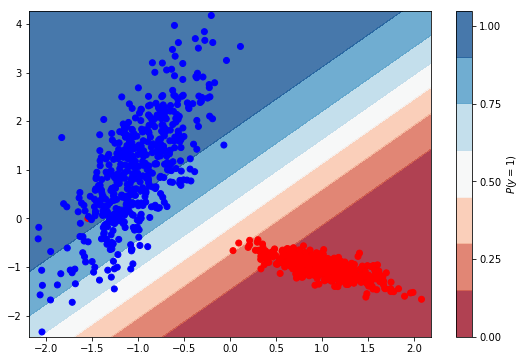

In [24]:
#Plot of the decision boundary
#The various shades of blue and red represent the probability of a hypothetical point in that area belonging to class 1 or 0.
plot_decision_boundary(lambda x: model.predict(x), X, y)

In [27]:
#Classification report showing the precision and recall of our model
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       501
           1       1.00      1.00      1.00       499

   micro avg       1.00      1.00      1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



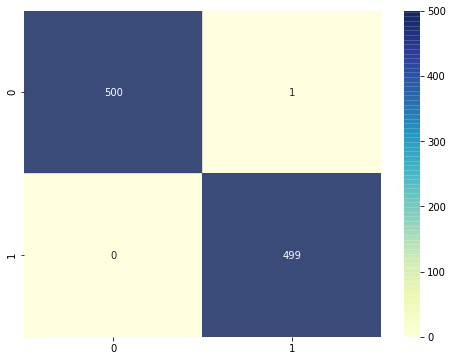

In [29]:
#confusion matrix
plot_confusion_matrix(model, X, y)

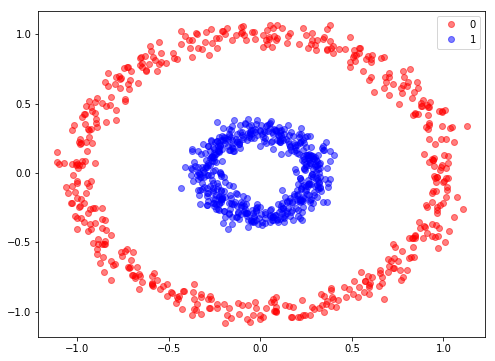

In [34]:
#This time I will create a more complex graph to show the power of ANN
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)
plot_data(X, y)

<Figure size 576x432 with 0 Axes>

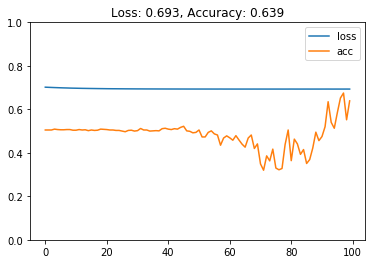

In [35]:
#Build a similar model as before
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)
plot_loss_accuracy(history)

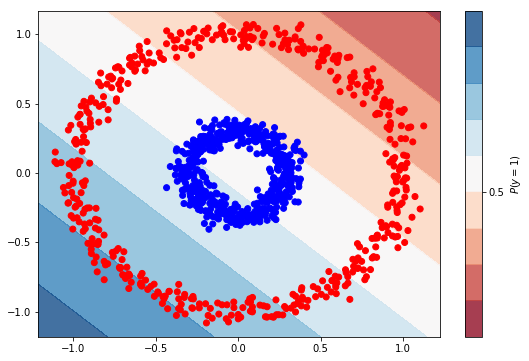

In [36]:
#Plot of the decision boundary
#The various shades of blue and red represent the probability of a hypothetical point in that area belonging to class 1 or 0.
plot_decision_boundary(lambda x: model.predict(x), X, y)

In [37]:
#Classification report showing the precision and recall of our model
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.38      0.54       500
           1       0.61      0.97      0.75       500

   micro avg       0.67      0.67      0.67      1000
   macro avg       0.76      0.67      0.64      1000
weighted avg       0.76      0.67      0.64      1000



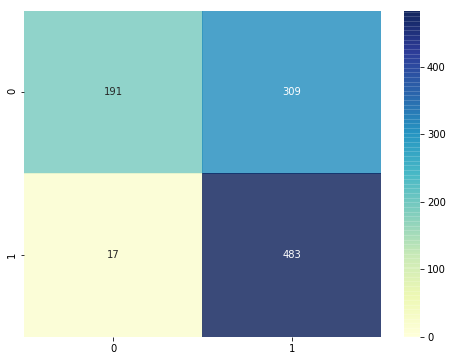

In [38]:
#confusion matrix
plot_confusion_matrix(model, X, y)

<Figure size 576x432 with 0 Axes>

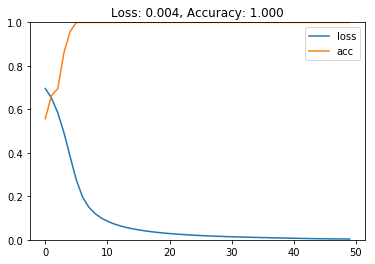

In [42]:
#We can see that clearly this model wasn't good enough. But we can do much better with a more complex model

#Define the model
model = Sequential()
model.add(Dense(units=4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

#compile the model
model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

#fit
history=model.fit(X, y, verbose=0, epochs=50)
#plot
plot_loss_accuracy(history)

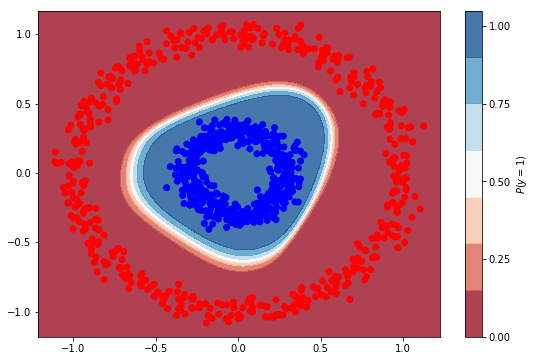

In [43]:
#Plot decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

   micro avg       1.00      1.00      1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



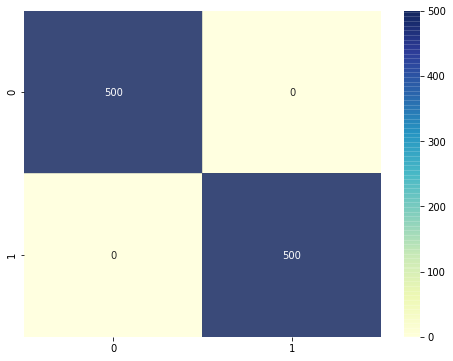

In [44]:
#Predict
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

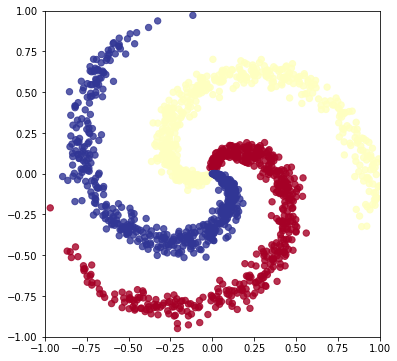

In [45]:
#Create a more complex plot
#We will use softmax regression this time - which is a generalization of logistic regression to the case where we want to handle multiple classes
X, y = make_multiclass(K=3)

<Figure size 576x432 with 0 Axes>

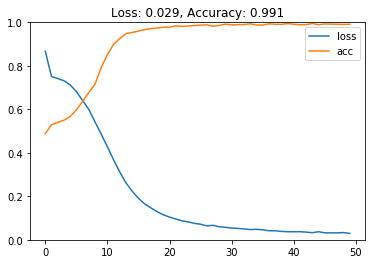

In [48]:
#Define the model
model = Sequential()
model.add(Dense(64, input_shape=(2,), activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(3, activation='softmax'))

#Compile
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

#Change to one-hot representation
y_cat = to_categorical(y)
#fit
history = model.fit(X, y_cat, verbose=0, epochs=50)
#plot
plot_loss_accuracy(history)

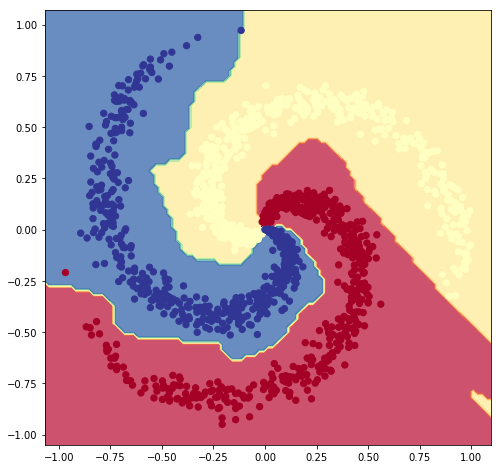

In [49]:
#Decision boundary
plot_multiclass_decision_boundary(model, X, y)

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       500
         1.0       1.00      0.99      0.99       500
         2.0       0.98      1.00      0.99       500

   micro avg       0.99      0.99      0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



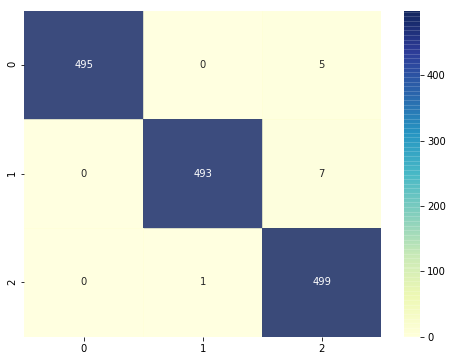

In [50]:
#Predict
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

In [52]:
#That was pretty neat wasn't it?
#Let's see how we can use it on a real dataset.
#I will use the Bill authenticator dataset- the goal is to predict the class of the bill (which indicate true bill or false one)

#Load data
dataset=pd.read_csv('C:\\Users\\sagi\\Desktop\\Learning\\ML\\Datasets\\bill_authentication.csv')

In [55]:
#Explore the data
print(dataset.shape)
print(dataset.info)
dataset.head()

(1372, 5)
<bound method DataFrame.info of       Variance  Skewness   Curtosis   Entropy  Class
0     3.621600   8.66610  -2.807300 -0.446990      0
1     4.545900   8.16740  -2.458600 -1.462100      0
2     3.866000  -2.63830   1.924200  0.106450      0
3     3.456600   9.52280  -4.011200 -3.594400      0
4     0.329240  -4.45520   4.571800 -0.988800      0
5     4.368400   9.67180  -3.960600 -3.162500      0
6     3.591200   3.01290   0.728880  0.564210      0
7     2.092200  -6.81000   8.463600 -0.602160      0
8     3.203200   5.75880  -0.753450 -0.612510      0
9     1.535600   9.17720  -2.271800 -0.735350      0
10    1.224700   8.77790  -2.213500 -0.806470      0
11    3.989900  -2.70660   2.394600  0.862910      0
12    1.899300   7.66250   0.153940 -3.110800      0
13   -1.576800  10.84300   2.546200 -2.936200      0
14    3.404000   8.72610  -2.991500 -0.572420      0
15    4.676500  -3.38950   3.489600  1.477100      0
16    2.671900   3.06460   0.371580  0.586190      0
17  

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


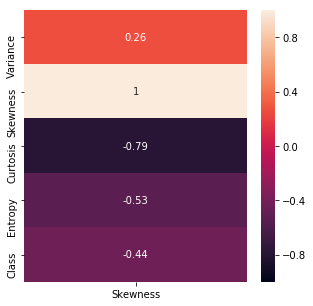

In [56]:
#check the correlation of the features with 'Skewness' 
plt.figure(figsize=(5, 5))
sns.heatmap(dataset.corr()[['Skewness']], annot=True, vmin=-1, vmax=1)

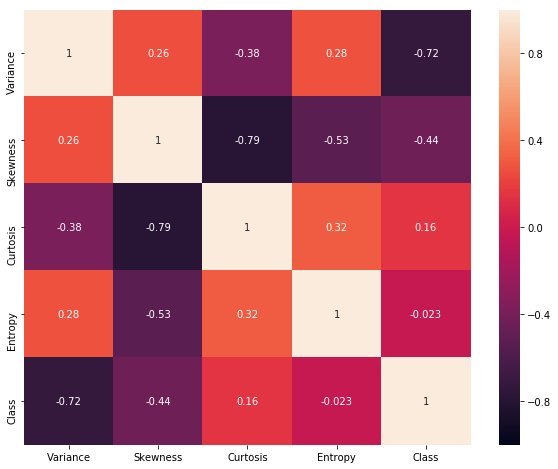

In [57]:
#check the correlation of the features with each other
plt.figure(figsize=(10, 8))
sns.heatmap(dataset.corr(), annot=True, vmin=-1, vmax=1)

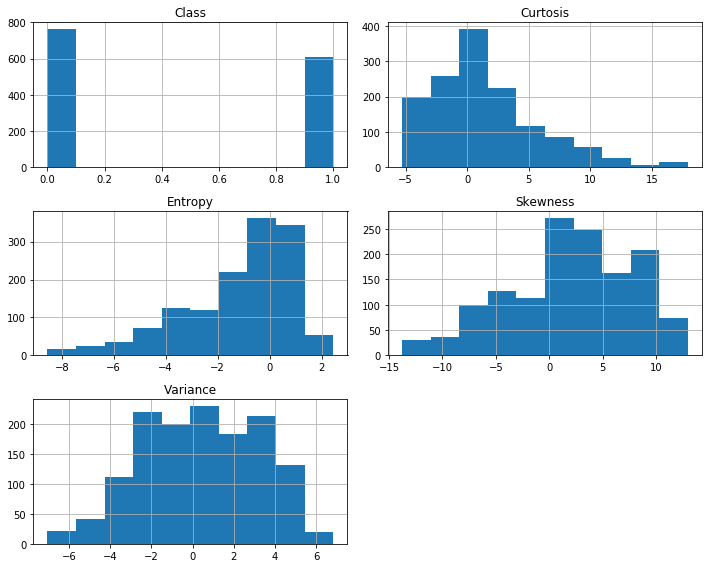

In [58]:
#Check the distribution of the feature values
dataset.hist(figsize=(10,8))
plt.tight_layout()

In [61]:
#Looks like we need to normalize some of them because they are not on the same scale.

#Copy and Normalize
df=dataset.copy()
ss=StandardScaler()
scale_features=['Skewness','Curtosis','Entropy','Variance']
df[scale_features] = ss.fit_transform(df[scale_features])

In [64]:
#Creating the training and testing
x=dataset.iloc[:, :4].values #convert data from pandas dataframe to numpy array using the values
y=dataset.iloc[:,4].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1097, 4) (1097,) (275, 4) (275,)


Epoch 1/50
1097/1097 [==============================] - 1s 667us/step - loss: 0.9336 - acc: 0.6135
Epoch 2/50
1097/1097 [==============================] - 0s 76us/step - loss: 0.4219 - acc: 0.8359
Epoch 3/50
1097/1097 [==============================] - 0s 73us/step - loss: 0.2504 - acc: 0.9608
Epoch 4/50
1097/1097 [==============================] - 0s 98us/step - loss: 0.1919 - acc: 0.9754
Epoch 5/50
1097/1097 [==============================] - 0s 146us/step - loss: 0.1584 - acc: 0.9854
Epoch 6/50
1097/1097 [==============================] - 0s 155us/step - loss: 0.1354 - acc: 0.9872
Epoch 7/50
1097/1097 [==============================] - 0s 97us/step - loss: 0.1193 - acc: 0.9909
Epoch 8/50
1097/1097 [==============================] - 0s 85us/step - loss: 0.1071 - acc: 0.9900
Epoch 9/50
1097/1097 [==============================] - 0s 143us/step - loss: 0.0973 - acc: 0.9918
Epoch 10/50
1097/1097 [==============================] - 0s 79us/step - loss: 0.0894 - acc: 0.9909
Epoch 11/50
109

<Figure size 576x432 with 0 Axes>

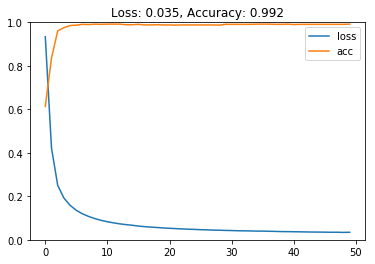

In [65]:
#Logistic Regression Model

#define the model
lr_model = Sequential()
lr_model.add(Dense(1, input_shape=(x_train.shape[1],), activation='sigmoid'))

#compile
lr_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

#fit
lr_history = lr_model.fit(x_train, y_train, verbose=1, epochs=50)
plot_loss_accuracy(lr_history)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       157
           1       0.98      1.00      0.99       118

   micro avg       0.99      0.99      0.99       275
   macro avg       0.99      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275



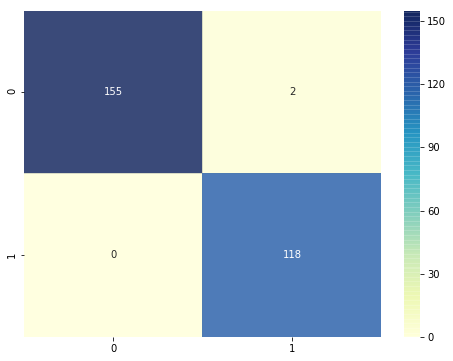

In [66]:
#predict
y_pred = lr_model.predict_classes(x_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lr_model, x_test, y_test)

<Figure size 576x432 with 0 Axes>

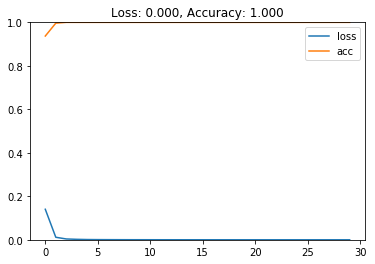

In [68]:
#ANN Model

deep_model = Sequential()
deep_model.add(Dense(64, input_shape=(x_train.shape[1],), activation='tanh'))
deep_model.add(Dense(16, activation='tanh'))
deep_model.add(Dense(1, activation='sigmoid'))

deep_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

deep_history = deep_model.fit(x_train, y_train, verbose=0, epochs=30)
plot_loss_accuracy(deep_history)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       157
           1       1.00      1.00      1.00       118

   micro avg       1.00      1.00      1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



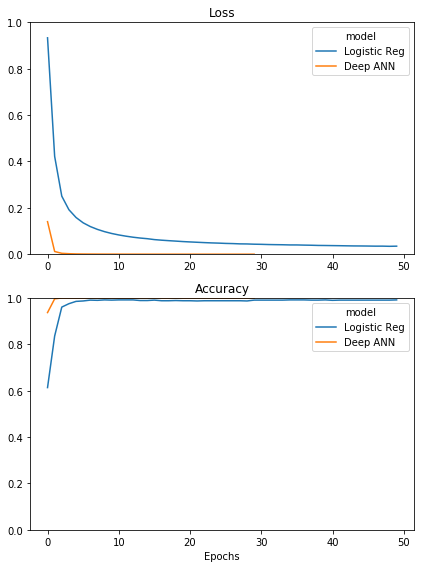

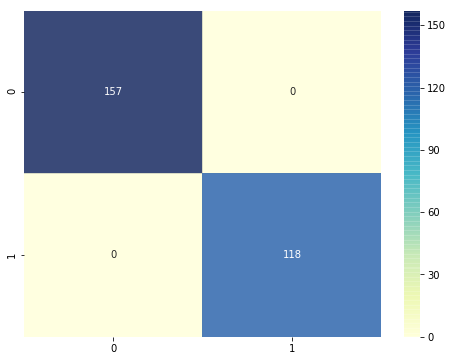

In [69]:
#Comparing results between LR and ANN
plot_compare_histories([lr_history, deep_history], ['Logistic Reg', 'Deep ANN'])
y_pred = deep_model.predict_classes(x_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(deep_model, x_test, y_test)